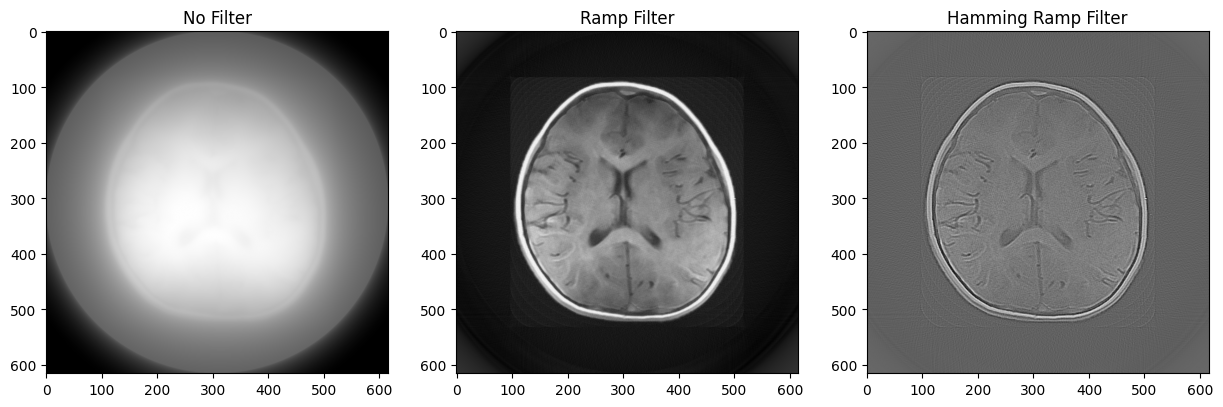

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from skimage.transform import rotate
from scipy.fftpack import rfft, irfft

# Load sinogram and extract metadata
sinogram = iio.imread("sinogram.png")
metadata = iio.immeta("sinogram.png")
aspect_ratio_str = metadata.get("AspectRatio", "4:3")
width_ratio, height_ratio = map(int, aspect_ratio_str.split(':'))

# Split RGB channels
red_sinogram, green_sinogram, blue_sinogram = sinogram[:, :, 0], sinogram[:, :, 1], sinogram[:, :, 2]

# Define the ramp filter
def ramp_filter(ffts):
    """Applies a ramp filter in the frequency domain."""
    ramp = np.floor(np.arange(0.5, ffts.shape[1]//2 + 0.1, 0.5))
    return ffts * ramp

# Define Hamming-windowed ramp filter
def hamming_ramp_filter(ffts):
    """Applies a ramp filter with Hamming window."""
    ramp = np.floor(np.arange(0.5, ffts.shape[1]//2 + 0.1, 0.5))
    hamming = np.hamming(len(ramp))
    return ffts * ramp * hamming

# Perform reconstruction

def reconstruct_image(sinogram, filter_fn=None):
    """Reconstructs an image from a sinogram using backprojection."""
    # Apply FFT to each row
    sinogram_fft = rfft(sinogram, axis=1)

    # Apply filter if specified
    if filter_fn:
        sinogram_fft = filter_fn(sinogram_fft)

    # Inverse FFT to get filtered sinogram
    filtered_sinogram = irfft(sinogram_fft, axis=1)

    # Backprojection
    steps, M = filtered_sinogram.shape
    laminogram = np.zeros((M, M))
    dTheta = 180.0 / steps
    for i in range(steps):
        temp = np.tile(filtered_sinogram[i], (M, 1))
        bp = rotate(temp, dTheta * i)
        laminogram += bp

    return laminogram

# Perform reconstructions
recon_no_filter = reconstruct_image(red_sinogram)
recon_ramp = reconstruct_image(red_sinogram, ramp_filter)
recon_hamming = reconstruct_image(red_sinogram, hamming_ramp_filter)

# Normalize results
def normalize_image(img):
    img = (img - img.min()) / (img.max() - img.min()) * 255
    return img.astype(np.uint8)

recon_no_filter = normalize_image(recon_no_filter)
recon_ramp = normalize_image(recon_ramp)
recon_hamming = normalize_image(recon_hamming)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(recon_no_filter, cmap='gray')
axes[0].set_title("No Filter")
axes[1].imshow(recon_ramp, cmap='gray')
axes[1].set_title("Ramp Filter")
axes[2].imshow(recon_hamming, cmap='gray')
axes[2].set_title("Hamming Ramp Filter")
plt.show()
